In [2]:
import pandas as pd
import numpy as np
import os
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import matthews_corrcoef, make_scorer, accuracy_score, f1_score, roc_curve
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

data_puno = pd.read_csv('..\Databases\peru_2018_2021.csv')
data_puno = data_puno.loc[data_puno.dep==21]

In [2]:
# Set the random seed for reproductible results
#Train test split
np.random.seed(0)

test = data_puno.loc[data_puno.year==2021]
train = data_puno.loc[data_puno.year<2021]

y_train, y_test = train["disasters_risk"], test["disasters_risk"]
x_train, x_test = train["disasters_risk"], test["disasters_risk"]

x_train = pd.concat([train.iloc[:,9:-3], train['gpc']], axis=1)
x_test = pd.concat([test.iloc[:,9:-3], test['gpc']], axis=1)

In [3]:
x_train.columns

Index(['inlaid_wall', 'painted_wall', 'paved_track', 'terrain_track', 'paths',
       'lighting_pole', 'no_public_good', 'independent_house',
       'improvised_house', 'own_house', 'title_ownership', 'concrete_walls',
       'concrete_floor', 'concrete_roof', 'household_house', 'water_network',
       'potable_water', 'water_quality_chlorine', 'water_daily_access',
       'drainage_network', 'electric_lighting', 'fuel_lighting',
       'candle_lighting', 'generator_lighting', 'other_lighting',
       'no_ligthing', 'electric_cooking', 'glp_cooking', 'gas_network_cooking',
       'charcoal_cooking', 'wood_cooking', 'other_cooking', 'manure_cooking',
       'no_cooking', 'phone', 'cellphone', 'cableTV', 'internet', 'rural',
       'altitude', 'overcrowding', 'fullbedroom_house', 'young_adult', 'adult',
       'old_adult', 'old', 'woman', 'married', 'literacy', 'no_education',
       'basic_education', 'technic_education', 'college_education',
       'posgraduate_education', 'illness', '

In [4]:
clf = RandomForestClassifier(n_jobs=1, random_state=0, bootstrap=True, max_features='sqrt')


pipe = Pipeline([('Scaler', RobustScaler()), ('RFC', clf)])

# Sensitivity True positive rate
def sensitivity(y_true,y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    if (cm[1,1]+cm[1,0])==0:
        sensitivity=0
    else:
        sensitivity = cm[1,1]/(cm[1,1]+cm[1,0])
    return sensitivity


In [5]:
def BSCV(K, n_iter, alpha, pipe):
    
    #Cost metric
    def cost_metric(y_true,y_predicted):
        cost_metric = alpha*matthews_corrcoef(y_true,y_predicted) + (1-alpha)*sensitivity(y_true,y_predicted)
        return cost_metric

    cv = RepeatedKFold(n_splits=K, n_repeats=2, random_state=0)
  
    param_grid = {
                "RFC__n_estimators": Integer(20,100, prior='uniform'),
                "RFC__criterion": Categorical(['gini', 'entropy', 'log_loss']),
                "RFC__max_depth": Integer(1,30, prior='uniform'),
                "RFC__min_samples_split": Integer(2,100, prior='uniform'),
                "RFC__min_samples_leaf": Integer(2,100, prior='uniform'),
                "RFC__ccp_alpha": Real(0, 0.1, prior='uniform'),
                }

    search_ddnn = BayesSearchCV(random_state=0, estimator=pipe, search_spaces=param_grid, 
                        scoring=make_scorer(cost_metric), cv=cv, n_jobs=-1, verbose=10,
                        n_iter=n_iter, return_train_score=True,
                        optimizer_kwargs={'base_estimator': 'GP', 'initial_point_generator': 'lhs'},
                        n_points=2, pre_dispatch='1*n_jobs')
    return search_ddnn


## Running this cell will perform RSCV

In [6]:
import time
start = time.time()

n_iter = 50
K= 10
alpha = 0.5
repeats=2
RFC_results1 =  BSCV(K=K, n_iter=n_iter, alpha=alpha, pipe=pipe).fit(x_train, y_train)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")


Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for each of 2 candidates, totalling 40 fits
Fitting 20 folds for eac

Sensitivity:  0.8089887640449438
Mathews Correlation Coefficient:  0.4864164401913182


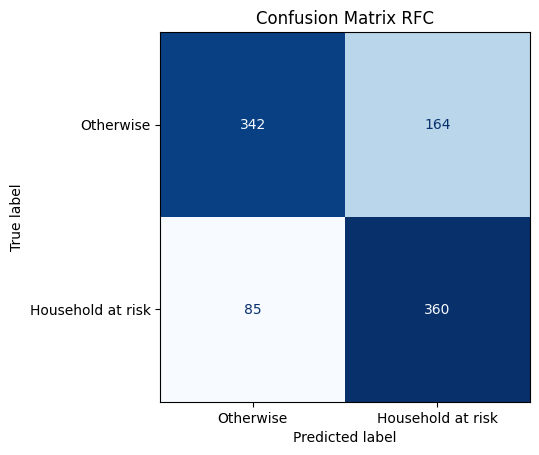

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = (RFC_results1.best_estimator_.predict_proba(x_test)[:,1] >= 0.5).astype(bool)
cm = confusion_matrix(y_test, predictions, labels=RFC_results1.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix RFC')

print('Sensitivity: ', sensitivity(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

Sensitivity:  0.8651685393258427
Mathews Correlation Coefficient:  0.5104653285288717
0.7507660878447395
0.7434279705573081
0.7593688362919132


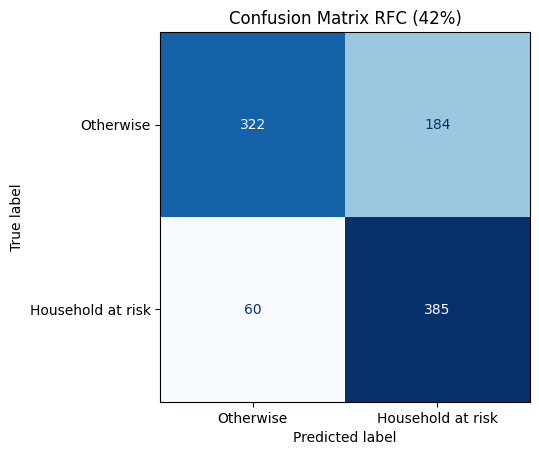

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, f1_score
import matplotlib.pyplot as plt

predictions = (RFC_results1.best_estimator_.predict_proba(x_test)[:,1] >= 0.42).astype(bool)
cm = confusion_matrix(y_test, predictions, labels=RFC_results1.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix RFC (42%)')

print('Sensitivity: ', sensitivity(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

print(roc_auc_score(y_test, predictions))
print(accuracy_score(y_test, predictions))
print(f1_score(y_test, predictions))

import time
start = time.time()

n_iter = 50
K= 10
alpha = 1 #All the importance to MCC
repeats=2
RFC_results2 =  BSCV(K=K, n_iter=n_iter, alpha=alpha, pipe=pipe).fit(x_train, y_train)

Total_time = (time.time() - start)
print("Training time: ", Total_time, " seconds")

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = RFC_results2.best_estimator_.predict(x_test)
cm = confusion_matrix(y_test, predictions, labels=RFC_results2.best_estimator_.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Otherwise", "Household at risk"])
disp.plot(cmap='Blues', colorbar=False)
plt.title('Confusion Matrix RFC')


print('Sensitivity: ', sensitivity(y_test, predictions))
print('Mathews Correlation Coefficient: ', matthews_corrcoef(y_test, predictions))

In [9]:
import pickle
filename1 = 'ENLR_puno_cost.sav'
filename2 = 'ENLR_puno.sav'
pickle.dump(RFC_results1.best_estimator_, open(filename1, "wb"))
#pickle.dump(RFC_results2.best_estimator_, open(filename2, "wb"))

In [10]:
# False positives
y_test

77494     0
77495     0
77496     0
77497     0
77498     0
         ..
101110    1
101111    1
101112    0
101113    0
101114    1
Name: disasters_risk, Length: 951, dtype: int64

In [11]:
pd.Series(RFC_results1.best_estimator_.predict(x_test), index=y_test.index)

77494     0
77495     0
77496     0
77497     0
77498     0
         ..
101110    1
101111    1
101112    1
101113    1
101114    1
Length: 951, dtype: int64

In [12]:
errors = pd.concat([y_test, pd.Series(RFC_results1.best_estimator_.predict(x_test), index=y_test.index, name='predictions')], axis=1)
#x_test['predictions'] = 

errors['false_negatives'] = ((errors.disasters_risk==1) & (errors.predictions==0)).astype('int')
errors['false_positives'] = ((errors.disasters_risk==0) & (errors.predictions==1)).astype('int')

errors

,disasters_risk,predictions,false_negatives,false_positives
77494,0,0,0,0
77495,0,0,0,0
77496,0,0,0,0
77497,0,0,0,0
77498,0,0,0,0
...,...,...,...,...
101110,1,1,0,0
101111,1,1,0,0
101112,0,1,0,1
101113,0,1,0,1


## Statistical analysis of false negatives and false positives

In [13]:
x_test.columns

Index(['inlaid_wall', 'painted_wall', 'paved_track', 'terrain_track', 'paths',
       'lighting_pole', 'no_public_good', 'independent_house',
       'improvised_house', 'own_house', 'title_ownership', 'concrete_walls',
       'concrete_floor', 'concrete_roof', 'household_house', 'water_network',
       'potable_water', 'water_quality_chlorine', 'water_daily_access',
       'drainage_network', 'electric_lighting', 'fuel_lighting',
       'candle_lighting', 'generator_lighting', 'other_lighting',
       'no_ligthing', 'electric_cooking', 'glp_cooking', 'gas_network_cooking',
       'charcoal_cooking', 'wood_cooking', 'other_cooking', 'manure_cooking',
       'no_cooking', 'phone', 'cellphone', 'cableTV', 'internet', 'rural',
       'altitude', 'overcrowding', 'fullbedroom_house', 'young_adult', 'adult',
       'old_adult', 'old', 'woman', 'married', 'literacy', 'no_education',
       'basic_education', 'technic_education', 'college_education',
       'posgraduate_education', 'illness', '

In [14]:
characteristics = ['terrain_track', 'paved_track', 'lighting_pole',
 'own_house', 'title_ownership', 'concrete_walls',
  'altitude', 'rural',
  'water_network', 'drainage_network',
  'electric_lighting', 'candle_lighting', 'other_lighting',
  'glp_cooking', 'manure_cooking',
  'internet', 'cellphone',
  'TVcolor', 'bicycle', 'motorcycle', 'DVD', 'car', 'computer_laptop', 'refrigerator', 'gpc',
  'young_adult', 'adult', 'old_adult', 'old', 'overcrowding', 'married', 'literacy', 'no_education', 'posgraduate_education',
  'illness', 'medical_attention', 'subsidized_hi', 'disabilities']
a = np.round(x_test.loc[errors.false_positives == 1, characteristics].mean().T, 4)
b = np.round(x_test.loc[errors.false_negatives == 1, characteristics].mean().T, 4)

descriptive = pd.concat([a,b], axis=1)
descriptive.columns = ['false_positives', 'false_negatives']
descriptive.to_csv('descriptive_post.csv')

In [15]:
x_test.loc[errors.false_negatives == 1, ['gpc', 'altitude', 'rural']].describe().T

,count,mean,std,min,25%,50%,75%,max
gpc,85.0,5789.319118,2711.929613,1794.064,3905.964,5272.699,7026.945,14658.48
altitude,85.0,3781.258824,647.751884,1410.000,3830.000,3860.000,3923.000,5079.00
rural,85.0,0.176471,0.383482,0.000,0.000,0.000,0.000,1.00


In [16]:
pd.concat([x_test, errors], axis=1).to_csv('post_estimation.csv', index=False)

In [17]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=4000, penalty='none', solver='lbfgs').fit(x_test, errors['false_negatives'])


feature_importances = pd.concat([pd.Series(clf.feature_names_in_), pd.DataFrame(clf.coef_.T)], axis=1)
feature_importances.columns = ['Features', 'Importances']
plt.figure(figsize=(6,10))
sorted_results = feature_importances.sort_values(by=['Importances'], ascending=False)


sns.barplot(data=sorted_results, y='Features', x='Importances', palette='GnBu_r')

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


NameError: name 'sns' is not defined

<Figure size 600x1000 with 0 Axes>

{'average': array([[0.08706645, 0.12040206]]),
 'values': [array([0, 1], dtype=int64)]}

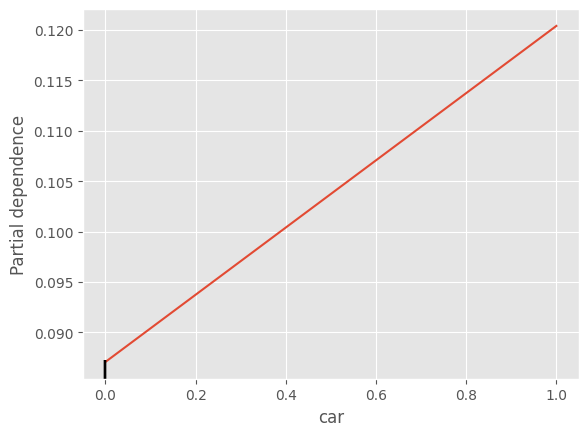

In [ ]:
from sklearn.inspection import PartialDependenceDisplay, partial_dependence
PartialDependenceDisplay.from_estimator(clf, x_test, ['car'])
partial_dependence(clf, x_test, ['car'])

In [ ]:
def marginal_effect_atmeans(model, x_matrix, feature_name):
    margins = partial_dependence(model, x_matrix, [feature_name])['average'][0][1] - partial_dependence(model, x_matrix, [feature_name])['average'][0][0]
    return margins

In [ ]:
marginal_effect_atmeans(clf, x_test, 'concrete_roof')

-0.04049559003595388

# Interpreting

In [ ]:
#pd.DataFrame(RFC_results1.best_estimator_['RFC'].coef_).T
#RFC_results1.best_estimator_.feature_names_in_

feature_importances = pd.concat([pd.Series(RFC_results1.best_estimator_.feature_names_in_), pd.DataFrame(RFC_results1.best_estimator_['RFC'].feature_importances_)], axis=1)
feature_importances.columns = ['Features', 'Importances']


<AxesSubplot: xlabel='Importances'>

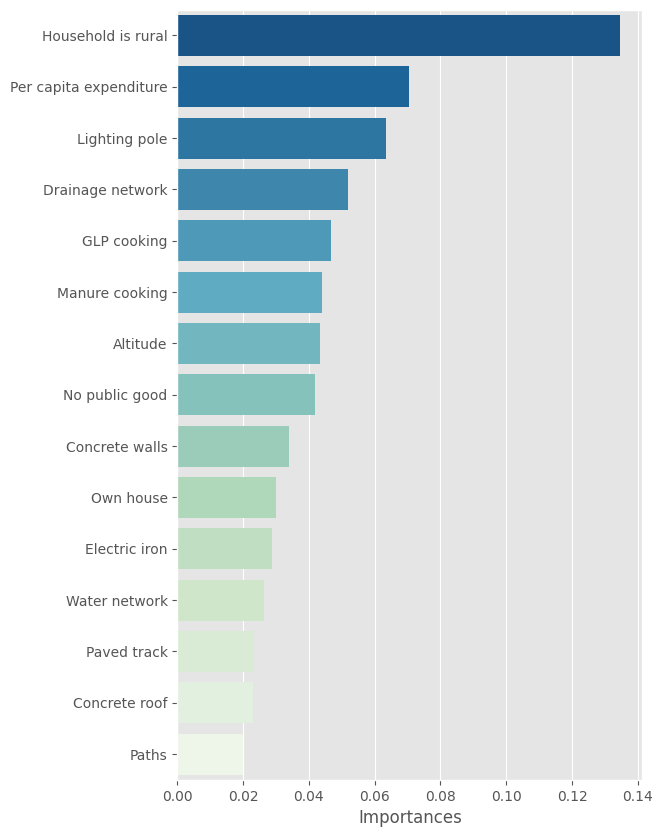

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x, Y, random_state=0, test_size=0.2, stratify=Y)
#ENLR_results1.best_estimator_.fit(x_train, y_train)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,10))
sorted_results = feature_importances.sort_values(by=['Importances'], ascending=False)

F = ['Household is rural', 'Per capita expenditure', 'Lighting pole', 'Drainage network',
     'GLP cooking', 'Manure cooking', 'Altitude', 'No public good', 'Concrete walls', 'Own house',
     'Electric iron', 'Water network', 'Paved track', 'Concrete roof', 'Paths']
sns.barplot(data=sorted_results[0:15], y=F, x='Importances', palette='GnBu_r')

In [ ]:
feature_importances.sort_values(by=['Importances'], ascending=False).Features.values[0:15]

array(['rural', 'gpc', 'lighting_pole', 'drainage_network', 'glp_cooking',
       'manure_cooking', 'altitude', 'no_public_good', 'concrete_walls',
       'own_house', 'electric_iron', 'water_network', 'paved_track',
       'concrete_roof', 'paths'], dtype=object)

In [ ]:
axs.flat

In [ ]:
best_features = feature_importances.sort_values(by=['Importances'], ascending=False).Features.values[0:15]

x_test.rename(columns={'rural': F[0], 'gpc': F[1],
                       'lighting_pole': F[2], 'drainage_network': F[3],
                       'glp_cooking': F[4], 'manure_cooking': F[5],
                       'altitude': F[6], 'no_public_good': F[7],
                       'concrete_walls': F[8], 'own_house': F[9],
                       'electric_iron': F[10], 'water_network': F[11],
                       'paved_track': F[12], 'concrete_roof': F[13],
                       'paths': F[14]}, inplace=True)

ValueError: Feature 'rural' not in feature_names

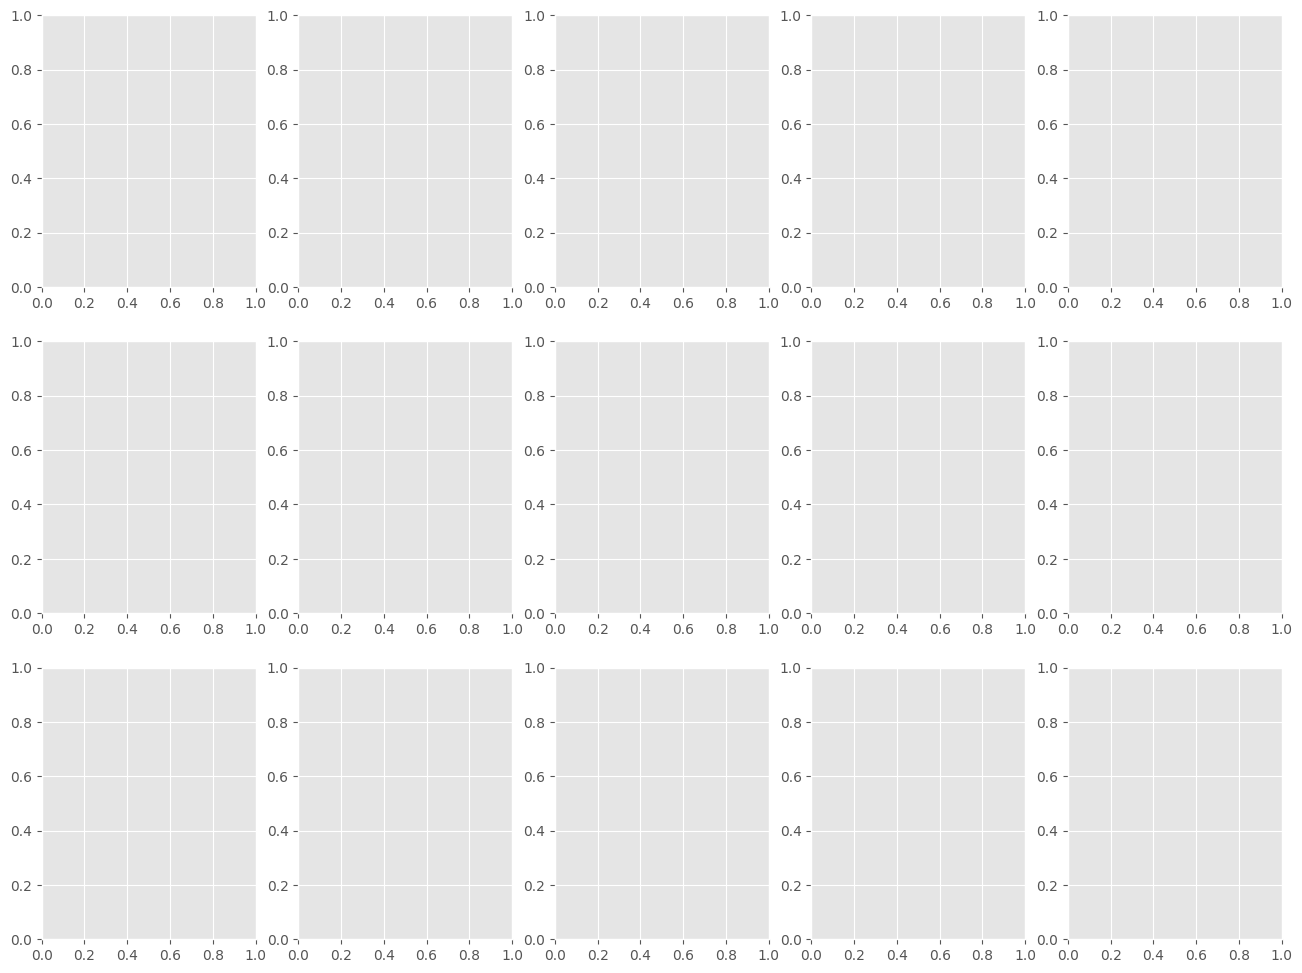

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
plt.style.use('ggplot')

fig, axs = plt.subplots(3,5, figsize=(16,12))
#fig.delaxes(axs[2,1])
#fig.delaxes(axs[2,2])
PartialDependenceDisplay.from_estimator(RFC_results1.best_estimator_, x_test, best_features, ax=axs)
axs[0,0].set(xlabel=F[0])
axs[0,1].set(xlabel=F[1])
axs[0,2].set(xlabel=F[2])
axs[0,3].set(xlabel=F[3])
axs[0,4].set(xlabel=F[4])
axs[1,0].set(xlabel=F[5])
axs[1,1].set(xlabel=F[6])
axs[1,2].set(xlabel=F[7])
axs[1,3].set(xlabel=F[8])
axs[1,4].set(xlabel=F[9])
axs[2,0].set(xlabel=F[10])
axs[2,1].set(xlabel=F[11])
axs[2,2].set(xlabel=F[12])
axs[2,3].set(xlabel=F[13])
axs[2,4].set(xlabel=F[14])

Text(0, 0.5, 'Probability of being at risk')

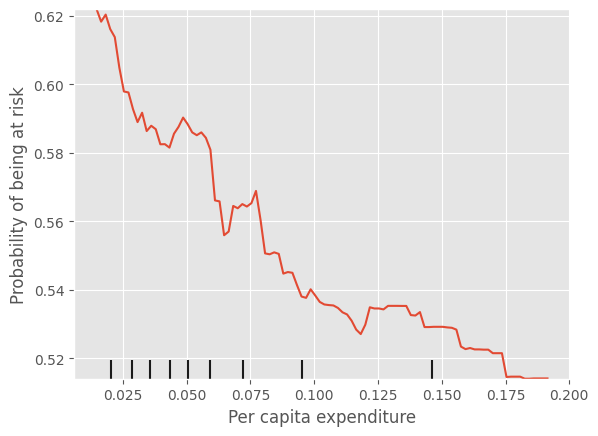

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
plt.style.use('ggplot')
partial_dependencies = PartialDependenceDisplay.from_estimator(winner_model, x, features=['gpc']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Per capita expenditure')
plt.ylabel('Probability of being at risk')

Text(0, 0.5, 'Probability of being at risk')

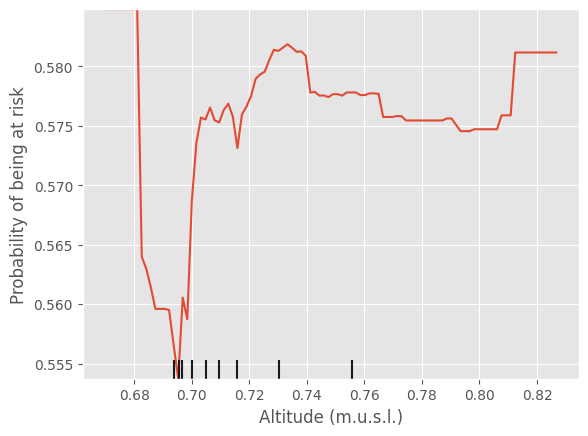

In [ ]:
PartialDependenceDisplay.from_estimator(winner_model, x, features=['altura']
                                        , response_method='predict_proba', method='brute')
plt.xlabel('Altitude (m.u.s.l.)')
plt.ylabel('Probability of being at risk')

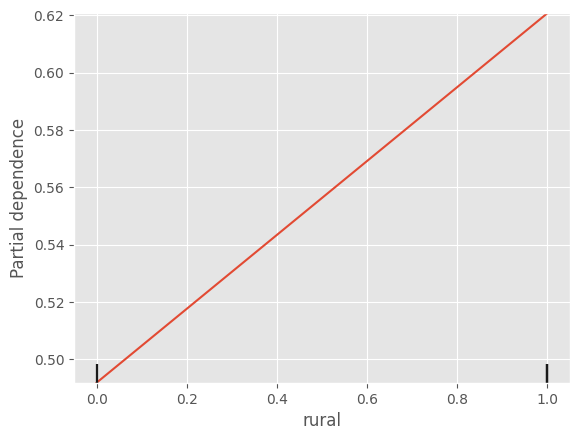

In [ ]:
PartialDependenceDisplay.from_estimator(winner_model, X=x, features=['rural']
                                        , response_method='predict_proba', method='brute')

In [ ]:
from sklearn.inspection import partial_dependence
resolution = 100

individual_conditional_expectations = (partial_dependence(winner_model, features=['gpc'], X=x, percentiles=(0.05,0.95),
                                grid_resolution=resolution, kind='individual'))

partial_dependencies = pd.DataFrame(individual_conditional_expectations['individual'].reshape(1106,resolution)
            , columns=individual_conditional_expectations['values'])

conditional_expectation = {'mean': [], 'std': []}

for i in np.arange(0,100, 1):
    conditional_expectation['mean'].append(partial_dependencies.iloc[:,i].mean())
    conditional_expectation['std'].append(partial_dependencies.iloc[:,i].std()**2)

conditional_expectation = pd.DataFrame(conditional_expectation)

<AxesSubplot:>

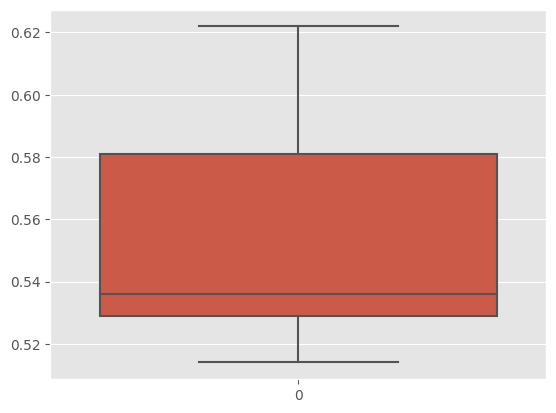

In [ ]:
sns.boxplot(conditional_expectation['mean'])

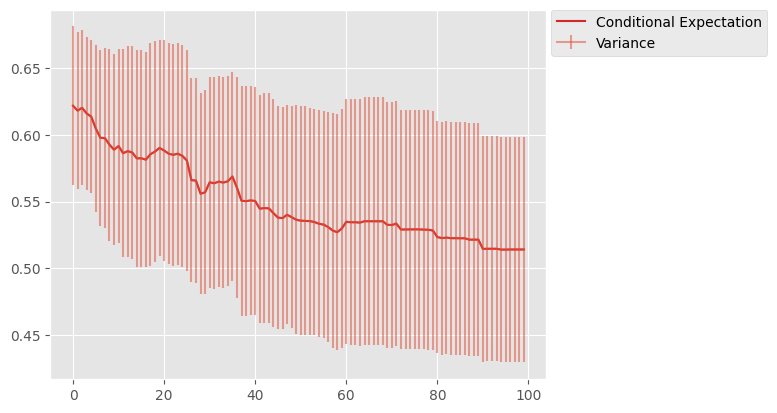

In [ ]:
plt.plot(conditional_expectation.index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(conditional_expectation.index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

Trade-off between resolution and variance, more resolution implies more variance over each point of the Grid

In [ ]:
individual_conditional_expectations['values']

[array([0.01469531, 0.01648074, 0.01826617, 0.0200516 , 0.02183703,
        0.02362245, 0.02540788, 0.02719331, 0.02897874, 0.03076416,
        0.03254959, 0.03433502, 0.03612045, 0.03790587, 0.0396913 ,
        0.04147673, 0.04326216, 0.04504759, 0.04683301, 0.04861844,
        0.05040387, 0.0521893 , 0.05397472, 0.05576015, 0.05754558,
        0.05933101, 0.06111644, 0.06290186, 0.06468729, 0.06647272,
        0.06825815, 0.07004357, 0.071829  , 0.07361443, 0.07539986,
        0.07718529, 0.07897071, 0.08075614, 0.08254157, 0.084327  ,
        0.08611242, 0.08789785, 0.08968328, 0.09146871, 0.09325414,
        0.09503956, 0.09682499, 0.09861042, 0.10039585, 0.10218127,
        0.1039667 , 0.10575213, 0.10753756, 0.10932299, 0.11110841,
        0.11289384, 0.11467927, 0.1164647 , 0.11825012, 0.12003555,
        0.12182098, 0.12360641, 0.12539184, 0.12717726, 0.12896269,
        0.13074812, 0.13253355, 0.13431897, 0.1361044 , 0.13788983,
        0.13967526, 0.14146069, 0.14324611, 0.14

In [ ]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
scaler.fit_transform(data_puno['gpc'].values.reshape(-1, 1))
index = scaler.inverse_transform(pd.DataFrame(individual_conditional_expectations['values'][0], columns=['gpc']))

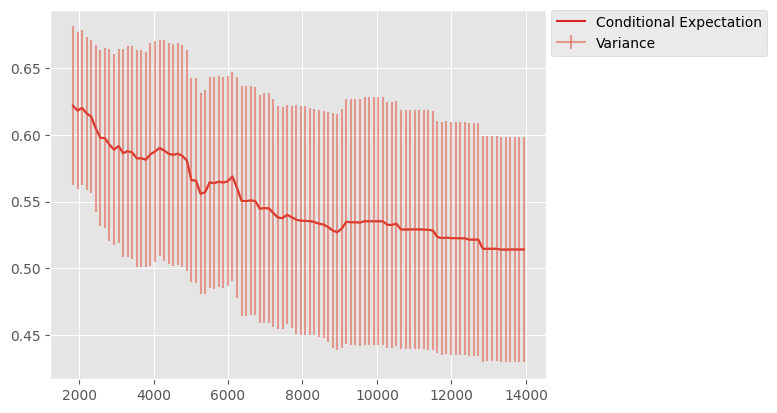

In [ ]:
plt.plot(index, conditional_expectation['mean'], color='tab:red', label='Conditional Expectation')
plt.errorbar(index, conditional_expectation['mean'], yerr=conditional_expectation['std'], alpha=0.5, label='Variance')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)